  # Autoencoder - SNNL Dev

# Setup

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import csv
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from typing import Dict, List, Tuple


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from tqdm import tqdm
import torch.nn.functional as F
from torchinfo import summary
import wandb

pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-SNNL-MAIN.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"
torch.set_num_threads(4)  ## <--- limit to ~ 2 CPUs
torch.get_num_threads()

insert ./src
insert ../..
['../..', './src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages/cytominer_eval-0.1-py3.11.egg']


4

In [3]:
from KevinsRoutines.utils.utils_wandb import init_wandb, wandb_log_metrics,wandb_watch
from KevinsRoutines.utils.utils_general import list_namespace, print_heading, print_underline

import snnl.utils as utils
from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from snnl.utils import plot_model_parms, plot_train_history, plot_regression_metrics
from snnl.utils import display_model_summary, display_model_hyperparameters, display_model_gradients, display_model_parameters
from snnl.utils import display_epoch_metrics, display_cellpainting_batch, display_model_state_dict
from snnl.utils import define_autoencoder_model, init_resume_training

In [4]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__) 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}  \t\t Number of threads: {torch.get_num_threads()}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" WandB version    : {wandb.__version__}  \t\t Pandas version: {pd.__version__}  ")
# logger.info(f" Search path      : {sys.path}")

2024-09-24 01:45:07,165 - __main__ - INFO: -  Excution started : 2024_09_24_01:45:07 
2024-09-24 01:45:07,166 - __main__ - INFO: -  Pytorch version  : 2.2.2  		 Number of threads: 4
2024-09-24 01:45:07,168 - __main__ - INFO: -  Scipy version    : 1.12.0  		 Numpy version : 1.26.4
2024-09-24 01:45:07,169 - __main__ - INFO: -  WandB version    : 0.17.4  		 Pandas version: 2.2.1  


### main(args)

In [5]:
GPU_ID = 1
LATENT_DIM    = 250
HIDDEN_1      = 512
EPOCHS        = 100

COMPOUNDS_PER_BATCH = 600
ADAM_WEIGHT_DECAY = 0.001
SNNL_FACTOR = 30.0

LEARNING_RATE = 1.00e-03
TEMP          = 1.00
TEMP_LR       = 0.00   ##1.0e-05


# LOAD_EPOCH = 100
# RUN_DATETIME = "20240917_2004"
# RUN_ID        = "kfzmaqko"
# CHECKPT = f"AE_snnl_dcpb{COMPOUNDS_PER_BATCH}_{LATENT_DIM}Ltnt_{HIDDEN_1}_{RUN_DATETIME}_LAST_ep_{LOAD_EPOCH:03d}.pt"
# CHECKPT = "AE_snnl_dcpb200_150Ltnt_512_20240709_2235_LAST_ep_700.pt"
# print(CHECKPT)

In [7]:
# if __name__ == "__main__":
cli_args = f" --runmode             snnl "\
            f" --configuration      hyperparameters/ae_snnl_{LATENT_DIM:03d}_{HIDDEN_1}_cpb.yaml" \
            f" --epochs             {EPOCHS} " \
            f" --single_loss        "\
            f" --prim_opt           "\
            f" --temp_annealing     "\
            f" --anneal_patience    30"\
            f" --adam_wd            {ADAM_WEIGHT_DECAY}"\
            f" --lr                 {LEARNING_RATE} "\
            f" --temp               {TEMP} "\
            f" --snnl_factor        {SNNL_FACTOR}"\
            f" --temp_lr            {TEMP_LR}"\
            f" --cpb                {COMPOUNDS_PER_BATCH}"\
            f" --seed               4321"\
            f" --gpu_id             {GPU_ID} "  \
            f" --wandb              "\
            f" "

# f" --run_id             {RUN_ID} "\
# f" --ckpt               {CHECKPT} " \
# f" --loss_factor        {LOSS_FACTOR}"\
# f" --temp_opt " \
# f" --configuration      hyperparameters/ae_sn_{LATENT_DIM:03d}{HIDDEN_1}{HIDDEN_2}_cpb.yaml" \
# f" --exp_title           snglOpt-050Ltnt_512_sig "
cli_args = utils.parse_args(cli_args.split())
cli_args

args = utils.load_configuration(cli_args)
args.ckpt

Namespace(configuration='hyperparameters/ae_snnl_250_512_cpb.yaml', ckpt=None, cpb=600, exp_title=None, epochs=100, gpu_id=1, learning_rate=0.001, exp_id=None, runmode='snnl', random_seed=4321, use_prim_optimizer=True, use_temp_optimizer=False, use_annealing=True, anneal_patience=30, use_single_loss=True, temperature=1.0, adam_weight_decay=0.001, loss_factor=None, snnl_factor=30.0, temperatureLR=0.0, WANDB_ACTIVE=True)

2024-09-24 01:46:37,420 - snnl.utils.utils_ptsnnl - INFO: -  command line param configuration             : [hyperparameters/ae_snnl_250_512_cpb.yaml]
2024-09-24 01:46:37,420 - snnl.utils.utils_ptsnnl - INFO: -  command line param ckpt                      : [None]
2024-09-24 01:46:37,421 - snnl.utils.utils_ptsnnl - INFO: -  command line param cpb                       : [600]
2024-09-24 01:46:37,422 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_title                 : [None]
2024-09-24 01:46:37,423 - snnl.utils.utils_ptsnnl - INFO: -  command line param epochs                    : [100]
2024-09-24 01:46:37,424 - snnl.utils.utils_ptsnnl - INFO: -  command line param gpu_id                    : [1]
2024-09-24 01:46:37,424 - snnl.utils.utils_ptsnnl - INFO: -  command line param learning_rate             : [0.001]
2024-09-24 01:46:37,426 - snnl.utils.utils_ptsnnl - INFO: -  command line param exp_id                    : [None]
2024-09-24 01:46:37,427 - snnl.utils.utils_ptsnn

In [8]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0.0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  30
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  600
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  240000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder.csv
    val_end..................  24000
    val_st

In [9]:
### Set random seed and gpu device
set_global_seed(args.random_seed)
if args.ckpt is not None:
    if os.path.exists(os.path.join('ckpts', args.ckpt)):
        logger.info(f"Checkpoint {args.ckpt} found")
        logger.info(f"Resuming training using checkpoint: {args.ckpt}")
    else:
        logger.error(f"*** Checkpoint {args.ckpt} not found *** \n")
        raise ValueError(f"\n *** Checkpoint DOESNT EXIST *** \n")

if args.gpu_id is not None:
    _ = get_device(verbose=True)
    args.current_device = set_device(args.gpu_id)
    print(f" args.current_device is : {args.current_device}")

 device: 0   Quadro GV100                   :  free: 33,423,949,824 B   (31.13 GB)    total: 34,069,872,640 B   (31.73 GB)
 device: 1   Quadro GV100                   :  free: 32,599,769,088 B   (30.36 GB)    total: 34,069,872,640 B   (31.73 GB)


2024-09-24 01:46:52,978 - snnl.utils.utils_ptsnnl - INFO: -  Current CUDA Device is:  cuda:0 - Quadro GV100
2024-09-24 01:46:52,980 - snnl.utils.utils_ptsnnl - INFO: -  Switched to: Quadro GV100 - 1


 device: 2   NVIDIA TITAN Xp                :  free: 12,464,029,696 B   (11.61 GB)    total: 12,774,539,264 B   (11.90 GB)
 args.current_device is : cuda:1


  ### WandB Setup

In [10]:
wandb_run = utils.setup_wandb(args)

2024-09-24 01:46:55,549 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find AE-SNNL-MAIN.ipynb.


None, AE_20240924_0146, CellPainting_Profiles


wandb: Currently logged in as: kbardool. Use `wandb login --relogin` to force relogin


2024-09-24 01:47:01,525 - snnl.utils.utils_notebook - INFO: -  Experiment Name  : AE_20240924_0146
2024-09-24 01:47:01,526 - snnl.utils.utils_notebook - INFO: -  Experiment Date  : 20240924_0146
2024-09-24 01:47:01,528 - snnl.utils.utils_notebook - INFO: - ***** Initialize NEW  W&B Run *****
2024-09-24 01:47:01,529 - snnl.utils.utils_notebook - INFO: - WANDB_ACTIVE     : True
2024-09-24 01:47:01,530 - snnl.utils.utils_notebook - INFO: - Project Name     : CellPainting_Profiles
2024-09-24 01:47:01,531 - snnl.utils.utils_notebook - INFO: - Experiment Id    : xhrj4rpq
2024-09-24 01:47:01,532 - snnl.utils.utils_notebook - INFO: - Experiment Name  : AE_20240924_0146
2024-09-24 01:47:01,533 - snnl.utils.utils_notebook - INFO: - Experiment Date  : 20240924_0146
2024-09-24 01:47:01,534 - snnl.utils.utils_notebook - INFO: - Experiment Title : dcpb600_250Ltnt_512
2024-09-24 01:47:01,535 - snnl.utils.utils_notebook - INFO: - Experiment Notes : AE snnl - SnglOpt, latent: 250, hidden_1: 512, cpb: 6

In [11]:
# if args.WANDB_ACTIVE:
#     wandb_run.finish()
#     WANDB_ACTIVE = False

  ### Define dataset and dataloaders

In [12]:
## Validation : 24,000
## Test: 12,000
## Train : 312,000 - (24,000+12,000) = 276,000
# cellpainting_args = {'sample_size': 3,
#                      'batch_size': 1,
#                      'compounds_per_batch': 600,
#                      'training_path'  : ALL_INPUT,
#                      'validation_path': ALL_INPUT,
#                      'test_path'      : ALL_INPUT,
#                      'train_start'    : 0,
#                      'train_end'      : 276_000,
#                      'val_start'      : 276_000,
#                      'val_end'        : 300_000,
#                      'test_start'     : 300_000,
#                      'test_end'       : 312_000,   ## 34_542
#                      }
# 
# args.cellpainting_args

In [13]:
# ## total rows = 346,542
# ## Validation :  24,542
# ## Train :      312,000 
args.cellpainting_args['training_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
args.cellpainting_args['train_start'] = 0 
args.cellpainting_args['train_end'] = 324_000

args.cellpainting_args['validation_path'] = '/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv'
args.cellpainting_args['val_start'] = 324_000
args.cellpainting_args['val_end'] = 346_542

In [14]:
#### Load CellPainting Dataset
data_loaders = utils.build_dataloaders(args, data = ['train', 'val'])
len(data_loaders['train']),len(data_loaders['val'])

2024-09-24 01:47:40,798 - root - INFO: -  load cellpainting
2024-09-24 01:47:40,800 - snnl.utils.dataloader - INFO: -  Building CellPantingDataset for train
2024-09-24 01:47:40,801 - snnl.utils.dataloader - INFO: -  filename:  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv
2024-09-24 01:47:40,802 - snnl.utils.dataloader - INFO: -  type    :  train
2024-09-24 01:47:40,802 - snnl.utils.dataloader - INFO: -  start   :  0
2024-09-24 01:47:40,803 - snnl.utils.dataloader - INFO: -  end     :  324000
2024-09-24 01:47:40,804 - snnl.utils.dataloader - INFO: -  numrows :  324000
2024-09-24 01:47:40,805 - snnl.utils.dataloader - INFO: -  names   :  None     usecols :  None
2024-09-24 01:47:40,805 - snnl.utils.dataloader - INFO: -  batch_size  :  1
2024-09-24 01:47:40,806 - snnl.utils.dataloader - INFO: -  sample_size :  3
2024-09-24 01:47:40,807 - snnl.utils.dataloader - INFO: -  compounds_per_batch :  600
2024-09-24 01:47

 load cellpainting
 Dataset size: 324000   rows per batch: 1800
 Dataset size: 22542   rows per batch: 1800


(324000, 22542)

In [15]:
# -----------------------------------------
#  Count pos/neg labels in each dataset
# -----------------------------------------  
MINIBATCH_SIZE = args.cellpainting_args['sample_size'] * args.cellpainting_args['compounds_per_batch']
train_minibatches = len(data_loaders['train']) // MINIBATCH_SIZE
val_minibatches = len(data_loaders['val']) // MINIBATCH_SIZE
# test_minibatches = len(data_loader['test']) // MINIBATCH_SIZE
print(f" Minibatch size : {MINIBATCH_SIZE:6d}") 
print(f" len of train data loader: {len(data_loaders['train']):7d}   number of batches: {train_minibatches:4d}    last batch: {len(data_loaders['train']) % MINIBATCH_SIZE:4d}")
print(f" len of valid data loader: {len(data_loaders['val']):7d}   number of batches: {val_minibatches:4d}    last batch: {len(data_loaders['val']) % MINIBATCH_SIZE:4d}")
# print(f" len of test  data loader: {len(data_loader['test'])}   number of batches: {test_minibatches}")

 Minibatch size :   1800
 len of train data loader:  324000   number of batches:  180    last batch:    0
 len of valid data loader:   22542   number of batches:   12    last batch:  942


In [16]:
from tqdm import tqdm
for datatype in ['train', 'val' ]:
    ttl_rows = 0
    ttl_pos_labels = 0 
    with tqdm(enumerate(data_loaders[datatype]), initial=0, total = train_minibatches, position=0, file=sys.stdout,
                   leave= False, desc=f" Read {datatype} ") as t_warmup:
        for batch_count, (batch_features, batch_labels, _, _, _, _) in t_warmup:
            ttl_rows += batch_labels.shape[0]
            ttl_pos_labels += batch_labels.sum()

    ttl_neg_labels = ttl_rows - ttl_pos_labels
    print(f"\n Dataset: {datatype}")
    print('-'*30)
    print(f" total rows     : {ttl_rows:7d}")
    print(f" total pos rows : {ttl_pos_labels:7.0f} - {ttl_pos_labels*100.0/ttl_rows:5.2f}%")
    print(f" total neg rows : {ttl_neg_labels:7.0f} - {ttl_neg_labels*100.0/ttl_rows:5.2f}%")

                                                                                                                                                                                                              
 Dataset: train
------------------------------
 total rows     :  324000
 total pos rows :   38586 - 11.91%
 total neg rows :  285414 - 88.09%
                                                                                                                                                                                                              
 Dataset: val
------------------------------
 total rows     :   22542
 total pos rows :    2742 - 12.16%
 total neg rows :   19800 - 87.84%


# Define autoencoder model

### Override arguments

In [17]:
# args.temperature   = 1.0
# args.loss_factor   = 1.0       ## 1.0e+00
# args.learning_rate = 1.0e-03    ## 0.001
# args.temperatureLR = 0.0e-04    ## 1e-4
print(f"   runmode               : {args.runmode}")
print(f"   embedding_layer       : {args.embedding_layer}")
print(f"   Latent dim            : {args.code_units}")
print(f"   loss_factor           : {args.loss_factor}")
print(f"   learning_rate         : {args.learning_rate}")
print(f"   use Primary Optimizer : {args.use_prim_optimizer}")
print(f"   use Primary Scheduler : {args.use_prim_scheduler}")
print(f"   snnl_factor           : {args.snnl_factor}")
print(f"   temperature           : {args.temperature}")
print(f"   use Temp Optimizer    : {args.use_temp_optimizer}")
print(f"   use Primary Scheduler : {args.use_temp_scheduler}")
print(f"   temperatureLR:        : {args.temperatureLR}")
print(f"   use_annealing:        : {args.use_annealing}")
print(f"   anneal_patience:      : {args.anneal_patience}")


   runmode               : snnl
   embedding_layer       : 4
   Latent dim            : 250
   loss_factor           : 1.0
   learning_rate         : 0.001
   use Primary Optimizer : True
   use Primary Scheduler : True
   snnl_factor           : 30.0
   temperature           : 1.0
   use Temp Optimizer    : False
   use Primary Scheduler : False
   temperatureLR:        : 0.0
   use_annealing:        : True
   anneal_patience:      : 30


In [18]:
list_namespace(args)


command line parms : 
-----------------------
SGD_momentum.............  0
SGD_weight_decay.........  0.0
WANDB_ACTIVE.............  True
adam_weight_decay........  0.001
anneal_patience..........  30
batch_size...............  1

    cellpainting_args   (dict)
    ----------------------------
    batch_size...............  1
    chunksize................  None
    compounds_per_batch......  600
    conversions..............  None
    iterator.................  True
    sample_size..............  3
    test_end.................  33600
    test_path................  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_test.csv
    test_start...............  30000
    train_end................  324000
    train_start..............  0
    training_path............  /home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv
    val_end..................  346542
    v

In [19]:
### Define Model
args.runmode
model = define_autoencoder_model(args, verbose = True)

'snnl'

2024-09-24 01:51:15,399 - snnl.utils.utils_notebook - INFO: - Defining model in SNNL mode 
2024-09-24 01:51:15,404 - snnl.models.autoencoder - INFO: -     layer pair:    0  type:linear           input:   1471  output:   1024    weights: [1024, 1471]   
2024-09-24 01:51:15,418 - snnl.models.autoencoder - INFO: -     layer pair:    1  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-24 01:51:15,419 - snnl.models.autoencoder - INFO: -     layer pair:    2  type:linear           input:   1024  output:    512    weights: [512, 1024]   
2024-09-24 01:51:15,425 - snnl.models.autoencoder - INFO: -     layer pair:    3  type:relu             input:      0  output:      0    weights: [0, 0]   
2024-09-24 01:51:15,426 - snnl.models.autoencoder - INFO: -     layer pair:    4  type:linear           input:    512  output:    250    weights: [250, 512]   
2024-09-24 01:51:15,429 - snnl.models.autoencoder - INFO: -     layer pair:    5  type:linear           input:    

 EMBEDDING LAYER: 4
 Device cuda:1 will be used

------------------------------------------------------------
 Building Base Model from NOTEBOOK
------------------------------------------------------------
    Model_init()_    -- mode:              latent_code
    Model_init()_    -- Unsupervised :     True
    Model_init()_    -- Support for unsupervised training  in 'latent_code' mode is True
    Model_init()_    -- Criterion:         MSELoss()
    Model_init()_    -- use_snnl :         True
    Model_init()_    -- temperature :      Parameter containing:
tensor([1.])
    Model_init()_    -- temperature LR:    0.0

------------------------------------------------------------
 Building Autoencoder from NOTEBOOK
------------------------------------------------------------
setup_prim_optimizer()
    AE init() -- mode               : latent_code
    AE init() -- unsupervised       : True
    AE init() -- layer_types        : ['linear', 'relu', 'linear', 'relu', 'linear', 'linear', 'relu'

## Resume from model checkpoint (if args.ckpt is not None)

In [20]:
args.load_checkpoint = utils.load_checkpoint_v5
args.save_checkpoint = utils.save_checkpoint_v5
# print(f" Checkpoint File :  {args.ckpt}")

model = init_resume_training(model, args)

if args.WANDB_ACTIVE:
    wandb_watch(item = model, criterion=None, log = 'all', log_freq = 1000, log_graph = False)
    wandb.config.update(args)

2024-09-24 01:51:19,960 - root - INFO: -  INITIALIZE TRAINING - Run 100 epochs: epoch 1 to 100 


In [21]:
# display_model_state_dict(model, 'test')
# display_model_parameters(model, 'title')
# display_model_gradients(model, 'test')
# display_model_hyperparameters(model)
# for k,v in model.__dict__.items():
#     if k == 'training_history':
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v.keys()} ")
#     else:
#         print(f" {k:30}  type: {str(type(v)):25s}   values: {v} ")
# model.optimizers['prim'].state_dict()
# model.schedulers['prim'].state_dict()
# print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}")
# for k,v in model.optimizers.items():
#     print(k, v)
# for k,v in enumerate(model.optimizers['prim'].param_groups[0]['params']):
#     print(f" {k}, {v.shape}")

# Autoencoder Fit 

In [22]:
#
#  Running Training Loop
#
logger.info(f" Experiment run id:  {args.exp_id}")
logger.info(f" Experiment Name  :  {args.exp_name} ")
logger.info(f" Experiment Date  :  {args.exp_date} ")
logger.info(f" Experiment Title :  {args.exp_title} ")
logger.info(f" Experiment Notes :  {args.exp_description}")

2024-09-24 01:51:26,158 - __main__ - INFO: -  Experiment run id:  xhrj4rpq
2024-09-24 01:51:26,159 - __main__ - INFO: -  Experiment Name  :  AE_20240924_0146 
2024-09-24 01:51:26,160 - __main__ - INFO: -  Experiment Date  :  20240924_0146 
2024-09-24 01:51:26,161 - __main__ - INFO: -  Experiment Title :  dcpb600_250Ltnt_512 
2024-09-24 01:51:26,162 - __main__ - INFO: -  Experiment Notes :  AE snnl - SnglOpt, latent: 250, hidden_1: 512, cpb: 600


In [23]:
# model.starting_epoch = 0
model.ending_epoch = 200
# model.starting_epoch, model.ending_epoch = 700, 705
model.starting_epoch, model.ending_epoch

print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

(0, 200)

 2024-09-24 01:51:27  epoch    1 of  200


In [31]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

 2024-09-24 19:11:44  Start: epoch  201 of  400
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
19:14:42 201/400  | 147.9186     0.6545   147.2641 |   0.373265   0.0000e+00 |   0.3055     5           | 169.7756     0.6503   169.1252 |   0.3102     5             |  1.250e-04   0.000e+00 |
19:17:38 202/400  | 147.9019     0.6556   147.2463 |   0.373265   0.0000e+00 |   0.3042     5           | 169.8174     0.6508   169.1666 |   0.3106     5             |  1.250e-04   0.000e+00 |              
19:20:35 203/400  | 147.7571     0.6569   147.1002 |   0.373265   0.0000e+00 |   0.3032     5           | 169.9903     0.6510   169.3393 |   0.3107     

2024-09-24 21:07:11,068 - snnl.models.base - INFO: -  Main learning rate reduced to [6.25e-05]


21:07:11 238/400  | 142.2456     0.6725   141.5730 |   0.342923   0.0000e+00 |   0.2879     5           | 171.1377     0.6635   170.4742 |   0.2966     5             |  1.250e-04   0.000e+00 |
21:10:08 239/400  | 142.2690     0.6715   141.5974 |   0.342923   0.0000e+00 |   0.2909     5           | 170.9202     0.6632   170.2571 |   0.2971     5             |  6.250e-05   0.000e+00 |              
21:13:05 240/400  | 141.8581     0.6714   141.1867 |   0.342923   0.0000e+00 |   0.2915     5           | 171.0690     0.6635   170.4055 |   0.2973     5             |  6.250e-05   0.000e+00 |              
21:16:00 241/400  | 141.5855     0.6723   140.9132 |   0.342923   0.0000e+00 |   0.2907     5           | 171.6797     0.6643   171.0155 |   0.2969     5             |  6.250e-05   0.000e+00 |              
21:18:58 242/400  | 141.5643     0.6727   140.8917 |   0.342923   0.0000e+00 |   0.2904     5           | 171.4768     0.6642   170.8127 |   0.2966     5             |  6.250e-05   0.000

2024-09-24 21:42:32,852 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_250.pt - epoch: 250


21:42:32 250/400  | 140.8279     0.6783   140.1496 |   0.342923   0.0000e+00 |   0.2845     5           | 172.2891     0.6694   171.6197 |   0.2915     5             |  6.250e-05   0.000e+00 |
21:45:31 251/400  | 140.7373     0.6786   140.0587 |   0.342923   0.0000e+00 |   0.2839     5           | 172.3108     0.6702   171.6406 |   0.2908     5             |  6.250e-05   0.000e+00 |              
21:48:30 252/400  | 140.6962     0.6795   140.0167 |   0.342923   0.0000e+00 |   0.2834     5           | 172.3062     0.6707   171.6355 |   0.2903     5             |  6.250e-05   0.000e+00 |              
21:51:30 253/400  | 140.6544     0.6796   139.9748 |   0.342923   0.0000e+00 |   0.2829     5           | 172.3430     0.6706   171.6724 |   0.2903     5             |  6.250e-05   0.000e+00 |              
 252 - anneal temp  -  counter: 7    before:   0.342923     new_temp:   0.318640 
21:54:30 254/400  | 137.6718     0.6800   136.9918 |   0.318640   0.0000e+00 |   0.2827     5           

2024-09-25 00:08:34,528 - snnl.models.base - INFO: -  Main learning rate reduced to [3.125e-05]


00:08:34 299/400  | 133.4686     0.6999   132.7688 |   0.298653   0.0000e+00 |   0.2627     5           | 172.5526     0.6901   171.8625 |   0.2708     5             |  6.250e-05   0.000e+00 |
                                                                                                                                                                                                              

2024-09-25 00:11:36,356 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_300.pt - epoch: 300


00:11:36 300/400  | 133.7037     0.6994   133.0043 |   0.298653   0.0000e+00 |   0.2643     5           | 172.4996     0.6885   171.8111 |   0.2737     5             |  3.125e-05   0.000e+00 |
00:14:36 301/400  | 133.5024     0.6994   132.8031 |   0.298653   0.0000e+00 |   0.2645     5           | 172.6467     0.6887   171.9580 |   0.2736     5             |  3.125e-05   0.000e+00 |              
00:17:36 302/400  | 133.3353     0.6998   132.6355 |   0.298653   0.0000e+00 |   0.2641     5           | 172.7937     0.6888   172.1048 |   0.2733     5             |  3.125e-05   0.000e+00 |              
00:20:36 303/400  | 133.2401     0.7002   132.5399 |   0.298653   0.0000e+00 |   0.2636     5           | 172.9362     0.6893   172.2469 |   0.2730     5             |  3.125e-05   0.000e+00 |              
00:23:33 304/400  | 133.1107     0.7004   132.4103 |   0.298653   0.0000e+00 |   0.2635     5           | 173.0439     0.6895   172.3544 |   0.2727     5             |  3.125e-05   0.000

2024-09-25 02:40:29,206 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_350.pt - epoch: 350


02:40:29 350/400  | 126.1494     0.7134   125.4360 |   0.267445   0.0000e+00 |   0.2505     5           | 174.3716     0.7046   173.6670 |   0.2577     5             |  3.125e-05   0.000e+00 |
02:43:28 351/400  | 126.1435     0.7135   125.4299 |   0.267445   0.0000e+00 |   0.2503     5           | 174.4343     0.7051   173.7293 |   0.2576     5             |  3.125e-05   0.000e+00 |              
02:46:28 352/400  | 126.0036     0.7138   125.2898 |   0.267445   0.0000e+00 |   0.2501     5           | 174.4090     0.7051   173.7039 |   0.2573     5             |  3.125e-05   0.000e+00 |              
02:49:26 353/400  | 125.9176     0.7139   125.2037 |   0.267445   0.0000e+00 |   0.2501     5           | 174.4340     0.7055   173.7286 |   0.2570     5             |  3.125e-05   0.000e+00 |              
02:52:24 354/400  | 125.8899     0.7141   125.1758 |   0.267445   0.0000e+00 |   0.2498     5           | 174.4992     0.7053   173.7939 |   0.2571     5             |  3.125e-05   0.000

2024-09-25 03:10:07,718 - snnl.models.base - INFO: -  Main learning rate reduced to [1.5625e-05]


03:10:07 360/400  | 125.6545     0.7147   124.9398 |   0.267445   0.0000e+00 |   0.2494     5           | 174.6907     0.7054   173.9853 |   0.2571     5             |  3.125e-05   0.000e+00 |
03:13:07 361/400  | 125.9868     0.7145   125.2723 |   0.267445   0.0000e+00 |   0.2501     5           | 174.5317     0.7043   173.8274 |   0.2582     5             |  1.563e-05   0.000e+00 |              
03:16:06 362/400  | 125.7462     0.7144   125.0318 |   0.267445   0.0000e+00 |   0.2502     5           | 174.6453     0.7043   173.9409 |   0.2581     5             |  1.563e-05   0.000e+00 |              
03:19:04 363/400  | 125.5476     0.7146   124.8330 |   0.267445   0.0000e+00 |   0.2499     5           | 174.7882     0.7047   174.0835 |   0.2578     5             |  1.563e-05   0.000e+00 |              
03:22:03 364/400  | 125.4048     0.7147   124.6901 |   0.267445   0.0000e+00 |   0.2498     5           | 174.8627     0.7049   174.1578 |   0.2575     5             |  1.563e-05   0.000

2024-09-25 05:09:32,799 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_400.pt - epoch: 400


05:09:32 400/400  | 121.6985     0.7181   120.9804 |   0.254947   0.0000e+00 |   0.2465     5           | 176.1800     0.7088   175.4712 |   0.2537     5             |  1.563e-05   0.000e+00 |
Last Epoch 400


2024-09-25 05:09:32,894 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_LAST_ep_400.pt - epoch: 400


 2024-09-25 05:09:32  End: epoch  400 of  400


In [36]:
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  Start: epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")
model.fit(args, data_loaders)
print(f" {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}  End: epoch {model.epoch + 1:4d} of {model.ending_epoch:4d}")

 2024-09-25 19:57:19  Start: epoch  401 of  600
  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |              
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
20:00:19 401/600  | 121.6740     0.7180   120.9560 |   0.254947   0.0000e+00 |   0.2466     5           | 176.1916     0.7088   175.4828 |   0.2537     5             |  1.563e-05   0.000e+00 |
20:03:17 402/600  | 121.6372     0.7182   120.9191 |   0.254947   0.0000e+00 |   0.2464     5           | 176.2649     0.7086   175.5563 |   0.2538     5             |  1.563e-05   0.000e+00 |              
20:06:15 403/600  | 121.6087     0.7182   120.8905 |   0.254947   0.0000e+00 |   0.2464     5           | 176.2988     0.7092   175.5896 |   0.2532     

2024-09-25 20:59:23,642 - snnl.models.base - INFO: -  Main learning rate reduced to [7.8125e-06]


20:59:23 421/600  | 119.1240     0.7194   118.4046 |   0.243967   0.0000e+00 |   0.2452     5           | 176.8340     0.7097   176.1243 |   0.2527     5             |  1.563e-05   0.000e+00 |
21:02:21 422/600  | 119.1699     0.7193   118.4506 |   0.243967   0.0000e+00 |   0.2456     5           | 176.9051     0.7092   176.1959 |   0.2534     5             |  7.813e-06   0.000e+00 |              
21:05:19 423/600  | 119.0497     0.7194   118.3303 |   0.243967   0.0000e+00 |   0.2455     5           | 177.0129     0.7092   176.3037 |   0.2534     5             |  7.813e-06   0.000e+00 |              
21:08:18 424/600  | 118.9845     0.7194   118.2651 |   0.243967   0.0000e+00 |   0.2454     5           | 177.0986     0.7091   176.3895 |   0.2534     5             |  7.813e-06   0.000e+00 |              
21:11:17 425/600  | 118.9490     0.7195   118.2296 |   0.243967   0.0000e+00 |   0.2454     5           | 177.1369     0.7092   176.4277 |   0.2533     5             |  7.813e-06   0.000

2024-09-25 22:25:19,621 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_450.pt - epoch: 450


22:25:19 450/600  | 116.6450     0.7201   115.9248 |   0.234223   0.0000e+00 |   0.2448     5           | 177.9752     0.7098   177.2654 |   0.2528     5             |  7.813e-06   0.000e+00 |
22:28:18 451/600  | 116.6055     0.7203   115.8852 |   0.234223   0.0000e+00 |   0.2447     5           | 177.9951     0.7098   177.2853 |   0.2528     5             |  7.813e-06   0.000e+00 |              
22:31:17 452/600  | 116.5768     0.7203   115.8566 |   0.234223   0.0000e+00 |   0.2447     5           | 178.0726     0.7098   177.3628 |   0.2528     5             |  7.813e-06   0.000e+00 |              
22:34:15 453/600  | 116.5585     0.7203   115.8382 |   0.234223   0.0000e+00 |   0.2447     5           | 178.0606     0.7099   177.3507 |   0.2527     5             |  7.813e-06   0.000e+00 |              
22:37:13 454/600  | 116.5434     0.7203   115.8231 |   0.234223   0.0000e+00 |   0.2447     5           | 178.0546     0.7098   177.3448 |   0.2528     5             |  7.813e-06   0.000

2024-09-26 00:00:10,020 - snnl.models.base - INFO: -  Main learning rate reduced to [3.90625e-06]


00:00:10 482/600  | 114.3241     0.7211   113.6031 |   0.225502   0.0000e+00 |   0.2440     5           | 178.7552     0.7107   178.0445 |   0.2521     5             |  7.813e-06   0.000e+00 |
00:03:07 483/600  | 114.3376     0.7211   113.6165 |   0.225502   0.0000e+00 |   0.2441     5           | 178.8315     0.7104   178.1211 |   0.2524     5             |  3.906e-06   0.000e+00 |              
00:06:06 484/600  | 114.2521     0.7211   113.5310 |   0.225502   0.0000e+00 |   0.2441     5           | 178.8821     0.7103   178.1717 |   0.2524     5             |  3.906e-06   0.000e+00 |              
00:09:02 485/600  | 114.2231     0.7212   113.5020 |   0.225502   0.0000e+00 |   0.2441     5           | 178.9133     0.7104   178.2029 |   0.2523     5             |  3.906e-06   0.000e+00 |              
00:12:00 486/600  | 114.2044     0.7212   113.4833 |   0.225502   0.0000e+00 |   0.2440     5           | 178.9287     0.7105   178.2182 |   0.2523     5             |  3.906e-06   0.000

2024-09-26 00:53:37,464 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_500.pt - epoch: 500


00:53:37 500/600  | 114.0445     0.7213   113.3232 |   0.225502   0.0000e+00 |   0.2439     5           | 179.0461     0.7107   178.3353 |   0.2521     5             |  3.906e-06   0.000e+00 |
00:56:35 501/600  | 114.0304     0.7214   113.3090 |   0.225502   0.0000e+00 |   0.2438     5           | 179.0528     0.7107   178.3420 |   0.2521     5             |  3.906e-06   0.000e+00 |              
 500 - anneal temp  -  counter: 15    before:   0.225502     new_temp:   0.217638 
00:59:33 502/600  | 112.3988     0.7214   111.6774 |   0.217638   0.0000e+00 |   0.2438     5           | 179.4062     0.7108   178.6954 |   0.2520     5             |  3.906e-06   0.000e+00 |              
01:02:31 503/600  | 112.3900     0.7215   111.6685 |   0.217638   0.0000e+00 |   0.2438     5           | 179.4354     0.7108   178.7245 |   0.2520     5             |  3.906e-06   0.000e+00 |              
01:05:32 504/600  | 112.3789     0.7214   111.6575 |   0.217638   0.0000e+00 |   0.2438     5          

2024-09-26 03:01:43,436 - snnl.models.base - INFO: -  Main learning rate reduced to [1.953125e-06]


03:01:43 543/600  | 110.3286     0.7220   109.6066 |   0.210500   0.0000e+00 |   0.2434     5           | 180.0986     0.7114   179.3872 |   0.2516     5             |  3.906e-06   0.000e+00 |
03:04:41 544/600  | 110.3529     0.7220   109.6309 |   0.210500   0.0000e+00 |   0.2435     5           | 180.1369     0.7112   179.4257 |   0.2517     5             |  1.953e-06   0.000e+00 |              
03:07:40 545/600  | 110.3064     0.7219   109.5844 |   0.210500   0.0000e+00 |   0.2435     5           | 180.1533     0.7112   179.4421 |   0.2517     5             |  1.953e-06   0.000e+00 |              
03:10:39 546/600  | 110.2905     0.7219   109.5686 |   0.210500   0.0000e+00 |   0.2435     5           | 180.1811     0.7113   179.4698 |   0.2517     5             |  1.953e-06   0.000e+00 |              
03:13:38 547/600  | 110.2800     0.7220   109.5580 |   0.210500   0.0000e+00 |   0.2435     5           | 180.1767     0.7113   179.4654 |   0.2517     5             |  1.953e-06   0.000

2024-09-26 03:22:33,905 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_550.pt - epoch: 550


03:22:33 550/600  | 110.2483     0.7220   109.5263 |   0.210500   0.0000e+00 |   0.2440     5           | 180.2188     0.7113   179.5075 |   0.2523     5             |  1.953e-06   0.000e+00 |
03:25:34 551/600  | 110.2385     0.7219   109.5166 |   0.210500   0.0000e+00 |   0.2442     5           | 180.2283     0.7113   179.5171 |   0.2524     5             |  1.953e-06   0.000e+00 |              
03:28:34 552/600  | 110.2307     0.7220   109.5087 |   0.210500   0.0000e+00 |   0.2441     5           | 180.2500     0.7113   179.5387 |   0.2523     5             |  1.953e-06   0.000e+00 |              
03:31:34 553/600  | 110.2219     0.7220   109.4999 |   0.210500   0.0000e+00 |   0.2441     5           | 180.2296     0.7113   179.5183 |   0.2524     5             |  1.953e-06   0.000e+00 |              
03:34:33 554/600  | 110.2139     0.7220   109.4919 |   0.210500   0.0000e+00 |   0.2443     5           | 180.2633     0.7113   179.5520 |   0.2530     5             |  1.953e-06   0.000

2024-09-26 05:51:35,598 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_ep_600.pt - epoch: 600
2024-09-26 05:51:35,687 - snnl.utils.utils_ptsnnl - INFO: -  Model exported to ckpts/AE_snnl_dcpb600_250Ltnt_512_20240924_0146_LAST_ep_600.pt - epoch: 600


05:51:35 600/600  | 107.0172     0.7223   106.2950 |   0.198009   0.0000e+00 |   0.2432     5           | 181.4682     0.7115   180.7566 |   0.2515     5             |  1.953e-06   0.000e+00 |
Last Epoch 600
 2024-09-26 05:51:35  End: epoch  600 of  600


In [ ]:
# model.use_temp_optimizer
# take_checkpoint(model, args, epoch=306, update_best = True)
# model.use_temp_optimizer
# model.temp_params
# model.anneal_patience = 30
# model.optimizers['prim'].param_groups[0]
# torch.get_num_threads()
# torch.set_num_threads(3)

In [26]:
model.epoch, model.starting_epoch, model.ending_epoch

(199, 0, 200)

In [37]:
for epoch in range(model.ending_epoch):
    display_epoch_metrics(model, epoch)

  time   ep / eps |  Trn_loss   Primary      SNNL  |   temp*         grad    |   R2      BestEp         |  Vld_loss   Primary      SNNL  |   R2       BestEp          |   LR        temp LR    |
------------------+--------------------------------+-------------------------+--------------------------+--------------------------------+----------------------------|------------------------|
01:54:38  1 /600  | 190.4737     0.7279   189.7458 |   1.000000   0.0000e+00 |  -6.4057     5           | 185.4568     0.5541   184.9027 |   0.2557     5             |  1.000e-03   0.000e+00 |
01:57:36  2 /600  | 186.0184     0.5256   185.4929 |   1.000000   0.0000e+00 |   0.3096     5           | 184.3893     0.4875   183.9019 |   0.2975     5             |  1.000e-03   0.000e+00 |
02:00:35  3 /600  | 185.1595     0.4897   184.6698 |   1.000000   0.0000e+00 |   0.3986     5           | 183.9005     0.4737   183.4268 |   0.4636     5             |  1.000e-03   0.000e+00 |
02:03:31  4 /600  | 184.5206     0.

In [35]:
# model.starting_epoch = 100
# model.ending_epoch = 200
# model.starting_epoch = 503
model.starting_epoch = model.ending_epoch
model.ending_epoch += 200

print(f" {datetime.now().strftime('%Y%m%d_%H%M%S')}  epoch {model.starting_epoch+1:4d} of {model.ending_epoch:4d}")

 20240925_195709  epoch  401 of  600


### Close WandB Logging

In [40]:
if args.WANDB_ACTIVE:
    wandb_run.finish()
    args.WANDB_ACTIVE = False

temp_grad_hist,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_hist,█████▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
temp_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_R2_score,█▇▇▆▇▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_best_loss,█████▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
trn_best_loss_ep,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
trn_best_metric,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_best_metric_ep,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_lr,████▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trn_prim_loss,▁▂▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇███████████████████
trn_snn_loss,█████▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁


## Misc stuff

# Plot losses, weights, biases and gradients

In [ ]:
# if 0:
#     model_attributes = model.__dict__
#     model.training_history['train'].keys()
#     for key, value in model.training_history['train'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")
#     print()
#     for key, value in model.training_history['val'].items():
#         if isinstance(value, List) or key in ["test_accuracy", "test_f1"]:
#             print(f"{key:25s} {type(value)}  {len(value):7d}  {value[-5:]}")        

# tmp = np.array(model.training_history['train']['temp_grads'])
# for st in range(0,len(tmp), 1000):
#     end = st + 1000
#     print(f" {st:5d} - {end:5d}  min: {tmp[st:end].min():9e}   max: {tmp[st:end].max():9e}    avg: {tmp[st:end].mean():9e}   std: {tmp[st:end].std():9e}")

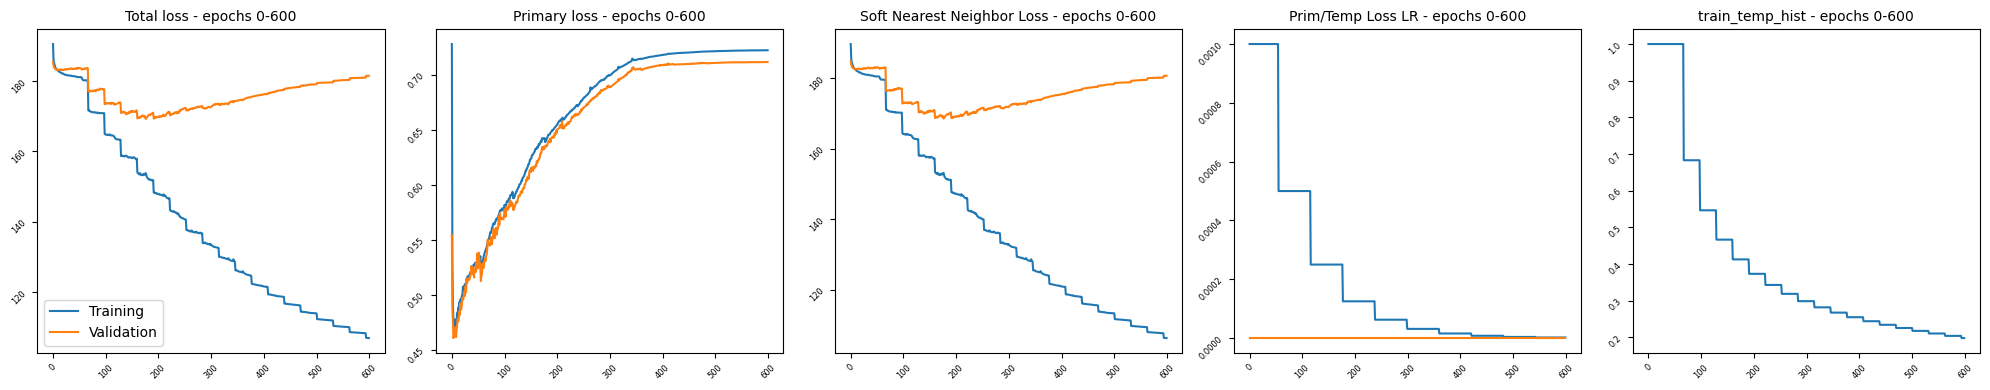

In [38]:
plot_train_history(model, start=0, n_bins = 25)

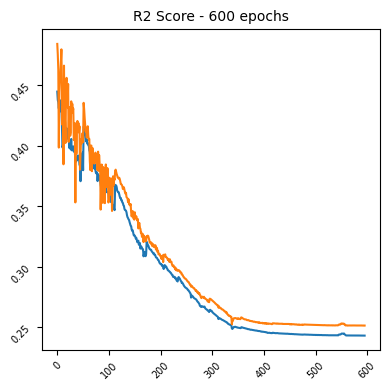

In [39]:
plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
# plot_train_metrics(model, n_bins = 25)
# plot_regression_metrics(model,start = 4, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 0, n_bins = 25)

In [ ]:
plot_train_history(model, start= 100, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

In [ ]:
plot_train_history(model, start= 10, n_bins = 25)

 +------+-------------------------------------------------------+----------------------------------------------+---------------------------------------+
 |      | Weights:                                              |  Biases:                                     |   Gradients:                          |
 | layr |                      min           max         stdev  |             min          max          stdev  |      min          max          stdev  |
 +------+-------------------------------------------------------+----------------------------------------------+---------------------------------------+
 |    0 | (1024, 1471)      -0.367781     0.320250     0.040307 |   1024   -0.874020     0.053638     0.140187 |   -0.862002     0.863193     0.036358 |
 |    1 | (512, 1024)       -0.731864     0.485091     0.034051 |    512   -0.672829     0.262521     0.096428 |   -2.257747     2.261386     0.040499 |
 |    2 | (250, 512)        -0.645375     0.713739     0.030737 |    250   -0.0049

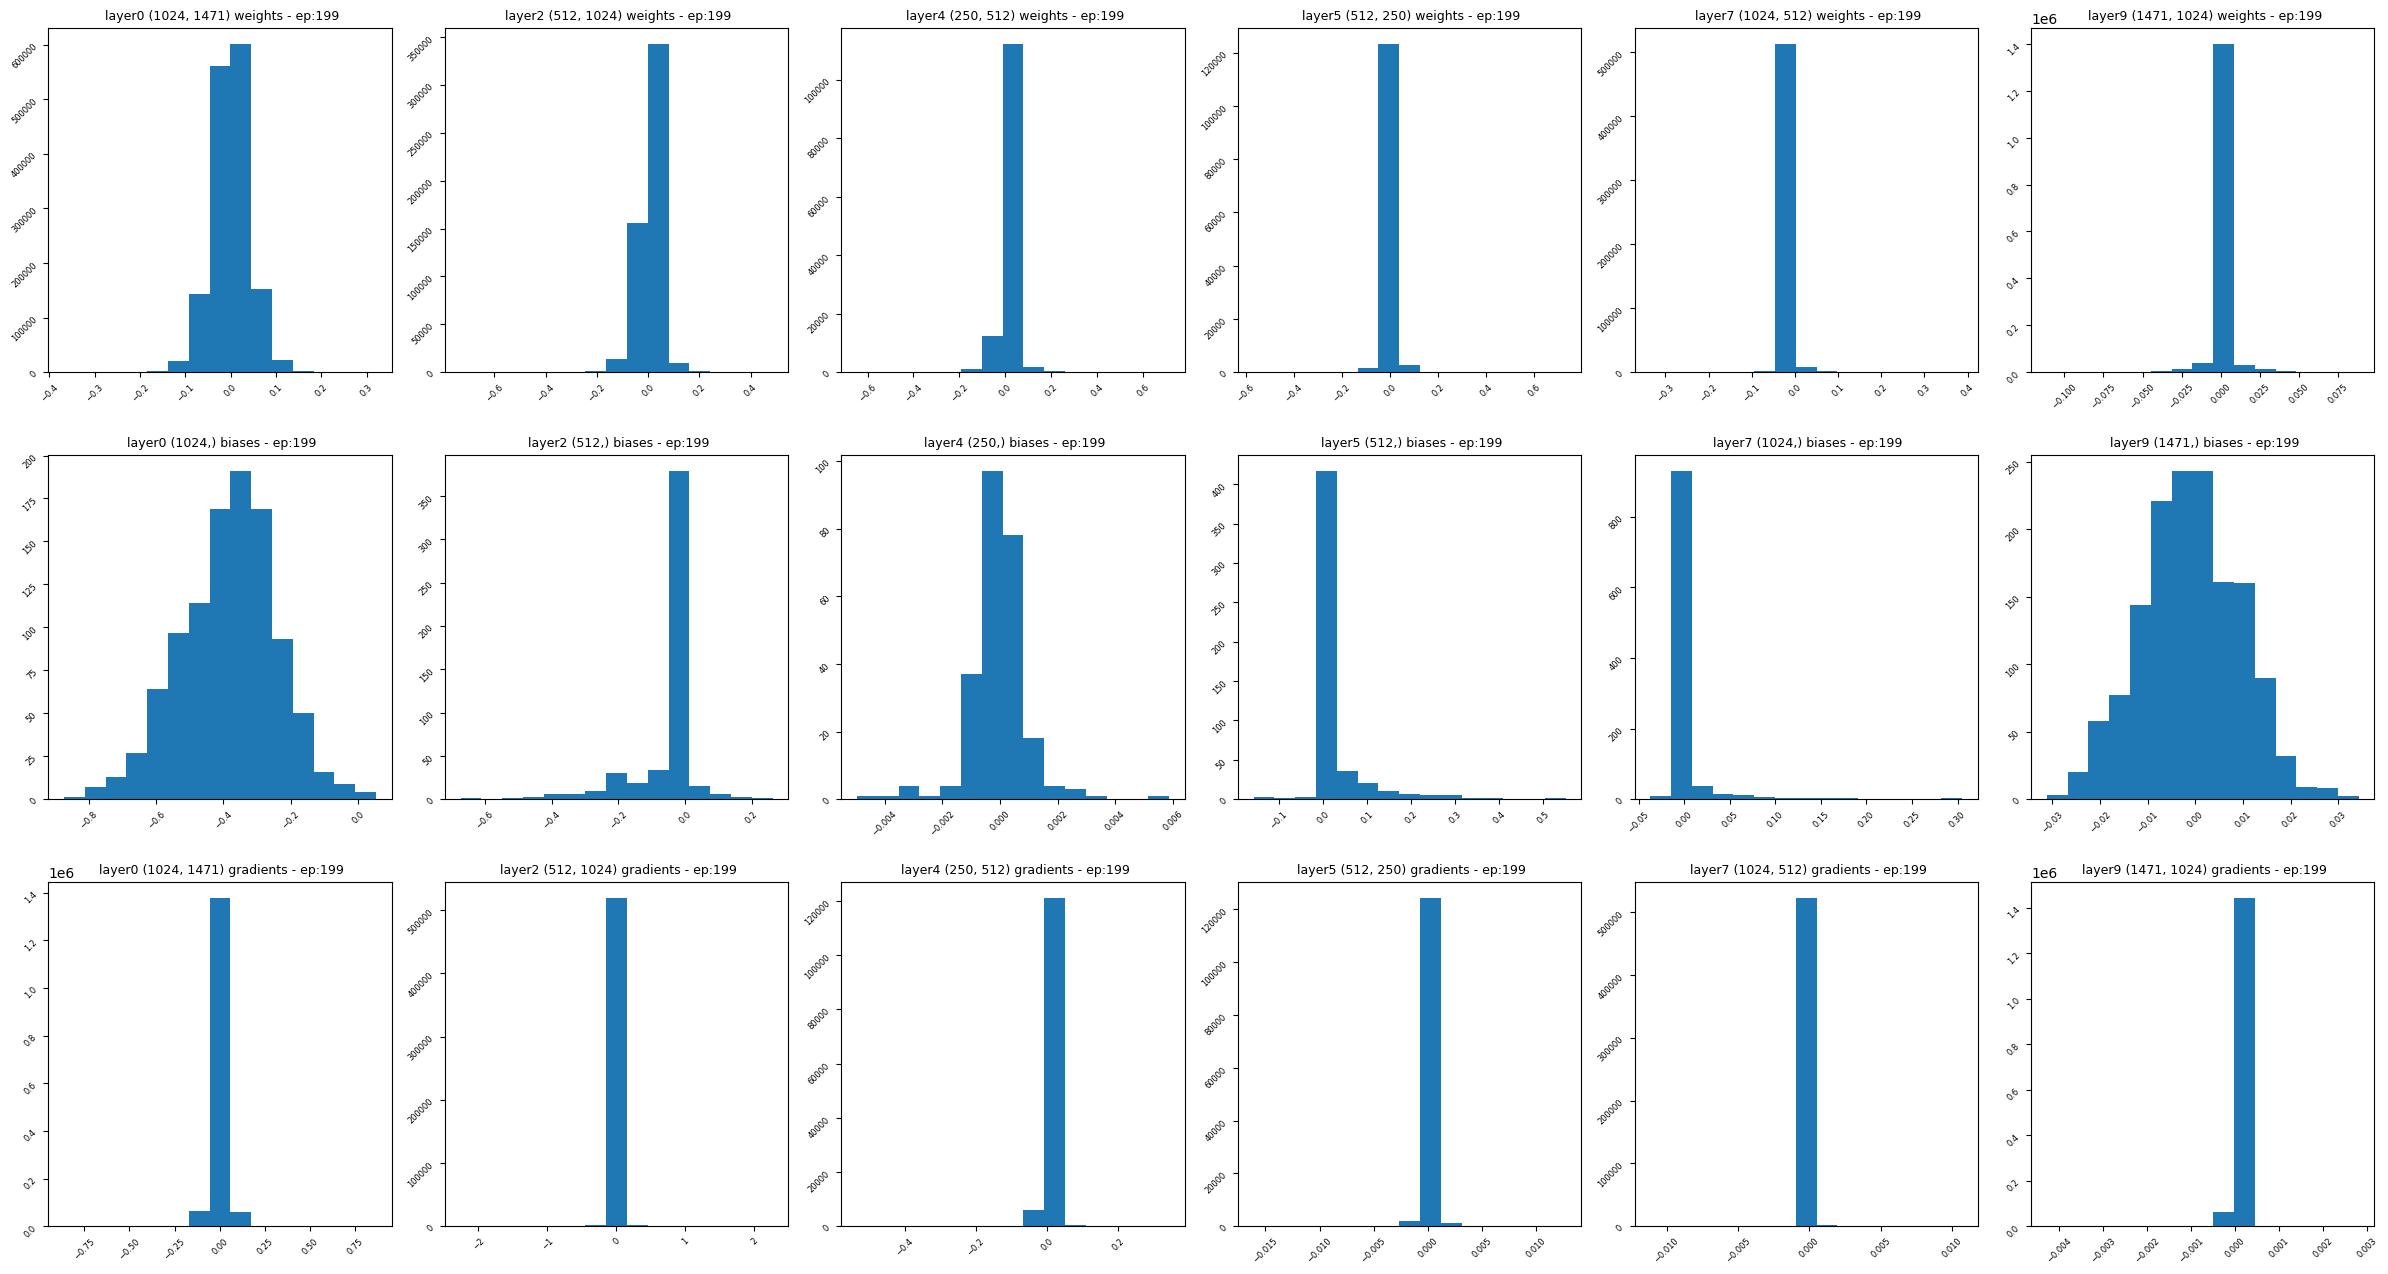

In [29]:
plot_model_parms(model, epochs= model.epoch, n_bins = 15)

# Load model

In [ ]:
ex_name = 'AE'
ex_epoch = 50
ex_runmode = 'snnl'
ex_date = '20240718'
ex_time = '1956'
ex_title = args.exp_title
compounds_per_batch = args.cpb
print(args.exp_title)
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
# ex_epoch = 200

In [ ]:
# filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"
# filename = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_{epochs:03d}_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
# file_pattern = f"{model.name}_{ex_runmode}_{ex_date}_{ex_title}_*_cpb_{ex_cpb}_factor_{ex_factor:d}.pt"
filename = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_{ex_epoch:03d}.pt"
print(filename)
file_pattern = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_BEST*.pt"
# file_pattern = f"{ex_name}_{ex_runmode}_{ex_title}_{ex_date}_{ex_time}_LAST*.pt"
print(file_pattern)

In [ ]:
import glob
filelist = glob.glob(file_pattern,root_dir = './ckpts')
filelist = sorted(filelist)
filelist
# epochlist =sorted([int(x[-6:-3]) for x in filelist])
# epochlist

In [ ]:
# runmode = 'snnl'
# ex_date = '20240516'
# ex_title = args.exp_title
ex_epoch = 200

filename = f"{model.name}_{args.runmode}_{exp_date}_{exp_title}_ep_{exp_epoch:03d}"
filename = filelist[0]
if filename[-3:] != '.pt':
    filename += '.pt'
print(filename)

if os.path.exists(os.path.join('ckpts', filename)):
    print(f"\n *** Checkpoint EXISTS *** \n")
else:
    print(f"\n *** Checkpoint DOESNT EXIST *** \n")

In [ ]:
# mdl , last_epoch = load_checkpoint_v2(model, filename)
mdl, last_epoch, mdl_ckpt = utils.load_checkpoint_v5(model, filename)
print(f" last epoch : {last_epoch}")

In [ ]:
print(args.current_device)
print(mdl.device)
# model.device = current_device
print(mdl.device)

In [ ]:
print(current_device)
model.train()
model = model.cuda(device=current_device)

In [ ]:
starting_epoch, epochs,

In [ ]:
print(f" last epoch  {last_epoch}")

In [ ]:
# starting_epoch = 20
starting_epoch = last_epoch
epochs = last_epoch + 100
# starting_epoch = epoch + 1
print(f" run epochs {starting_epoch+1} to {epochs} ")

In [ ]:
print()
print(f" model device              : {model.device}")
print(f" model temperature         : {model.temperature}")
print(f" model use prim_optimizer  : {model.use_prim_optimizer}")
print(f" model use prim_scheduler  : {model.use_prim_scheduler}")
print() 
print(f" loss_factor               : {model.loss_factor}")
print(f" monitor_grads_layer       : {model.monitor_grads_layer}")
print(f" Learning rate             : {model.optimizers['prim'].param_groups[0]['lr']}") 
print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].param_groups[0]}") 
print() 
print(f" Optimizer ParamGroup[0]   : {model.optimizers['prim'].state_dict()}") 

print(f" snnl_factor               : {model.snnl_factor}")
# if model.use_snnl:
#     print(f" temperature          : {model.temperature.item()}")
# if model.temp_optimizer is not None:
#     print(f" Temperature LR       : {model.temp_optimizer.param_groups[0]['lr']}") 
# print()

# for th_key in ['trn', 'val']:
#     for k,v in model.training_history[th_key].items():
#         if isinstance(v[-1],str):
#             print(f" {k:20s} : {v[-1]:s}  ")
#         else:
#             print(f" {k:20s} : {v[-1]:6f} ")
#     print()


In [ ]:
model.optimizers['prim']['params']
# model.use_prim_scheduler

In [ ]:
model.optimizers 
print()

In [ ]:
model.scheduler.__dict__

In [ ]:
model.temp_optimizer.__dict__
print()

In [ ]:
model.temp_scheduler.__dict__